# 2. Mapping: Mean-State and Seasonal Difference Plots
### Authors

Samantha Stevenson sstevenson@ucsb.edu

### Table of Contents

[Goals](#purpose)

[Import Packages, Define Time Periods and Regions](#setup)

[Read in Data and Concatenate Data Arrays](#data_io)

[Calculate Time Averages Over Specified Periods, Seasons](#time_avg)

[Plot Difference Maps](#map)


<a id='purpose'></a> 
## **Goals**

In this tutorial, we will be creating difference maps to show how patterns of surface air temperature have changed over time. This tutorial is an extension of tutorial 1 in this repo. New skills encountered in this tutorial:

1. _Concatenating_ data from multiple netCDF files

2. Plotting data from different _seasons_


We'll be working with data from MULTIPLE files today! Direct links are below:

#### [File 1 for Today: Historical tas from CanESM5 member r10i1p1f1](https://drive.google.com/file/d/1TaWe1hs6Lgr-AEM1y74xGA3EBaECyMMV/view?usp=sharing)

#### [File 2 for Today: SSP370 tas from CanESM5 member r10i1p1f1](https://drive.google.com/file/d/1WDAWoepRTliqkFmQMF9D8jF0e_FwA2KG/view?usp=drive_link)

These files can also be downloaded from the [Earth System Grid Federation MetaGrid site](https://aims2.llnl.gov) (see the [Web download tutorial](https://climate-datalab.org/data-download-from-web/) if you need more information on how to do this).

<a id='setup'></a> 
## **Import Packages, Define Time Periods and Regions**

We'll import the necessary packages first, which are the same as the ones we used in tutorial 1:

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Before we go to the step of reading in the data, we'll *first* set up some _parameters_ that the rest of the notebook will use. It's good to set these up front, where they're hard to miss! We'll specify two arrays, which hold:

- our _region of interest_ for plotting: this is specified in the format [minimum longitude, maximum longitude, minimum latitude, maximum latitude] but you can change this around if you want
- our _time periods of interest_ which will be used later for averaging: this is specified in the format [start year, end year] with one array for each time period

**NOTE: specifying these as arrays is not required!** If you're more comfortable with "hard coding" the numbers in, that's fine - we're just including this here to get you used to some coding best practices.

In the example below, the region of interest is set to cover the continental United States, and two time periods are defined:
- Early (`per_early`): the last 50 years up till now
- Late (`per_late`): the next 50 years

In [2]:
# Array with region of interest
# [lon_min, lon_max, lat_min, lat_max]
region = [230, 295, 25, 51]

# Array with time periods of interest
# [starting year, ending year]
per_early = [1975, 2025]
per_late = [2026, 2075]

<a id='data_io'></a> 
## **Read in Data and Concatenate Data Arrays**

We next need to read in our data. But now we'll do it slightly differently than in tutorial 1, since we need to read in data from multiple files.

#### Why are multiple files necessary?

Take a look at the filenames for the two files provided here:
- tas_Amon_CanESM5_historical_r10i1p1f1_gn_185001-201412.nc
- tas_Amon_CanESM5_ssp370_r10i1p1f1_gn_201501-210012.nc

The date strings at the end of the filenames tell you what years are included in each (for more information on the filenames, also refer to our [filename decoder](http://www.climate-datalab.org/filename-decoder)). The historical data file contains years 1850-2014, and the future projection (here, SSP3-7.0) contains years 2015-2100. Since we're trying to average data over the period 1975-2025, that means that we need information from both data files! And of course, the future part of the record is contained entirely in the second data file.

#### Concatenation: xarray `concat`
The easiest way to deal with this is to read in BOTH data files as xarray Datasets, then concatenate them. xarray has a built-in function to handle this, called [concat](https://docs.xarray.dev/en/stable/generated/xarray.concat.html):


In [7]:
# Read in data as xarray Dataset
# historical
data_hist = xr.open_dataset('/courses/EDS296/tas_Amon_CanESM5_historical_r10i1p1f1_gn_185001-201412.nc')

#ssp370
data_ssp = xr.open_dataset('/courses/EDS296/tas_Amon_CanESM5_ssp370_r10i1p1f1_gn_201501-210012.nc')

# concatenate
data = xr.concat([data_hist, data_ssp], dim="time")

To make sure that the concat function did what it's supposed to do, we can do some printing of the various datasets:

In [8]:
# Print data
print("Historical data file:")
print(data_hist)

Historical data file:
<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/53)
    CCCma_model_hash:            55f484f90aff0e32c5a8e92a42c6b9ae7ffe6224
    CCCma_parent_runid:          rc3.1-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his10
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:              

From this, we see that the historical data file contains information for 1980 months, which makes sense for a file that's supposed to contain monthly averages over 165 years.

We can do the same thing for the SSP370 data file:

In [9]:
print("SSP370 data file:")
print(data_ssp)

SSP370 data file:
<xarray.Dataset>
Dimensions:    (time: 1032, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/53)
    CCCma_model_hash:            24718c8346665b218729640ffe79d263b76456c4
    CCCma_parent_runid:          rc3.1-his10
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-s7010
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   2015:01:01:00
    ...                          ...
    tracking_id:                 hd

For comparison, the concatenated data file has a longer time dimension, that's equal to the sum of the lengths of the `time` coordinates in the historical and SSP370 files:

In [6]:
print("Concatenated data file:")
print(data)

Concatenated data file:
<xarray.Dataset>
Dimensions:    (time: 3012, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 1850-01-01 00:00:00 ... 2101-01-01 00:00:00
    lat_bnds   (time, lat, bnds) float64 -90.0 -86.58 -86.58 ... 86.58 90.0
    lon_bnds   (time, lon, bnds) float64 -1.406 1.406 1.406 ... 355.8 358.6
    tas        (time, lat, lon) float32 250.9 250.7 250.4 ... 275.7 275.7 275.7
Attributes: (12/53)
    CCCma_model_hash:            55f484f90aff0e32c5a8e92a42c6b9ae7ffe6224
    CCCma_parent_runid:          rc3.1-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his10
    Convent

_Brief note on units_: In the previous tutorial, we converted the temperature units from Kelvin to Celsius. I have not done that here because we're going to be calculating _differences_ between time periods, and the _size_ of a degree is the same in Kelvin or Celsius so you end up getting the same answer. If you want to look at an individual epoch, though, you may want to consider converting as we did in tutorial 1!

<a id='time_avg'></a> 
## **Calculate Time Averages Over Specified Periods, Seasons**

Now we can proceed with the rest of our analysis, following the same steps as before!

We use the `.sel` and `slice` commands to create subsetted data over the two time periods we're interested in. 

**Note: here we specify the inputs to slice using the `per_early` and `per_late` arrays we defined at the beginning!**

In [10]:
# Select data within the ranges of years specified above

# Early period
data_early = data.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))

# Late period
data_late = data.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))

### Annual mean
We can simply average over the time dimension to get our two-dimensional datasets to use in the plot. This will result in our mean-state differences including all seasons (i.e. an annual mean):

In [11]:
# Calculate time averages
data_early_annmn = data_early.mean(dim="time")
data_late_annmn = data_late.mean(dim="time")

### Seasonal mean

For some applications, we might want to know how the changes are spread across different seasons. This could influence melting patterns of snow, for instance, or the seasonal growth of plants - the examples are endless. But whatever your application, the time handling functionality of xarray can help you out!
 
Since xarray is derived partially from pandas, it has a lot of the same time functionality. See the xarray [Time Series Data](https://docs.xarray.dev/en/latest/user-guide/time-series.html) page for more details! 

Here we'll take advantage of the built-in seasons that xarray recognizes:
- DJF
- MAM
- JJA
- SON

where the letters above stand for calendar months (i.e. DJF = "December-January-February" and so on). To access this information, we can use the `dt` functionality within xarray: this is a way of using time differences specified in various formats to group data, which can then be used to construct averages.

The code block below uses the `season` option within `dt` to select only those portions of the datasets for the early and late periods which fall within DJF:

In [12]:
# Extract data associated with the DJF season
# early period
data_early_DJF = data_early.sel(time=data_early.time.dt.season=="DJF")

# late period
data_late_DJF = data_late.sel(time=data_late.time.dt.season=="DJF")

Print out the data to see what it looks like:

In [13]:
data_early_DJF

<xarray.Dataset>
Dimensions:    (time: 153, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 1975-01-16 12:00:00 ... 2025-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 1975-01-01 00:00:00 ... 2026-01-01 00:00:00
    lat_bnds   (time, lat, bnds) float64 -90.0 -86.58 -86.58 ... 86.58 90.0
    lon_bnds   (time, lon, bnds) float64 -1.406 1.406 1.406 ... 355.8 358.6
    tas        (time, lat, lon) float32 249.1 248.9 248.7 ... 249.3 249.3 249.4
Attributes: (12/53)
    CCCma_model_hash:            55f484f90aff0e32c5a8e92a42c6b9ae7ffe6224
    CCCma_parent_runid:          rc3.1-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his10
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/5ed65f32-a352-4bd1-83a4-c659b4f...
    variable_id:                 tas
    variant_label:               r10i1p1f1
    version:                     v20190429
    license:                     CMIP6 model data produced by The Government ...
    cmor_version:                3.4.0

We can see by comparing the length of the time coordinate in `data_early_DJF` to the unfiltered time in `data_early` that it's now four times smaller: that's because we've now extracted all data in the months of December, January, or February and excluded the other 9 months of every year. 

We can now use this to calculate a time average that represents just the DJF season:

In [14]:
# Calculate DJF mean during both time periods
# early
data_early_DJFmn = data_early_DJF.mean(dim="time")

# late
data_late_DJFmn = data_late_DJF.mean(dim="time")

<a id='map'></a> 
## **Plot Difference Maps**

Now we're finally ready to plot our difference maps! We'll do two versions:

- The annual mean including all calendar months; and
- The mean just over the DJF season.

This will follow the same plotting steps we used in tutorial 1, and we'll restrict our spatial domain to the continental US to make things a little more focused.

First, the plot of annual mean temperature differences:

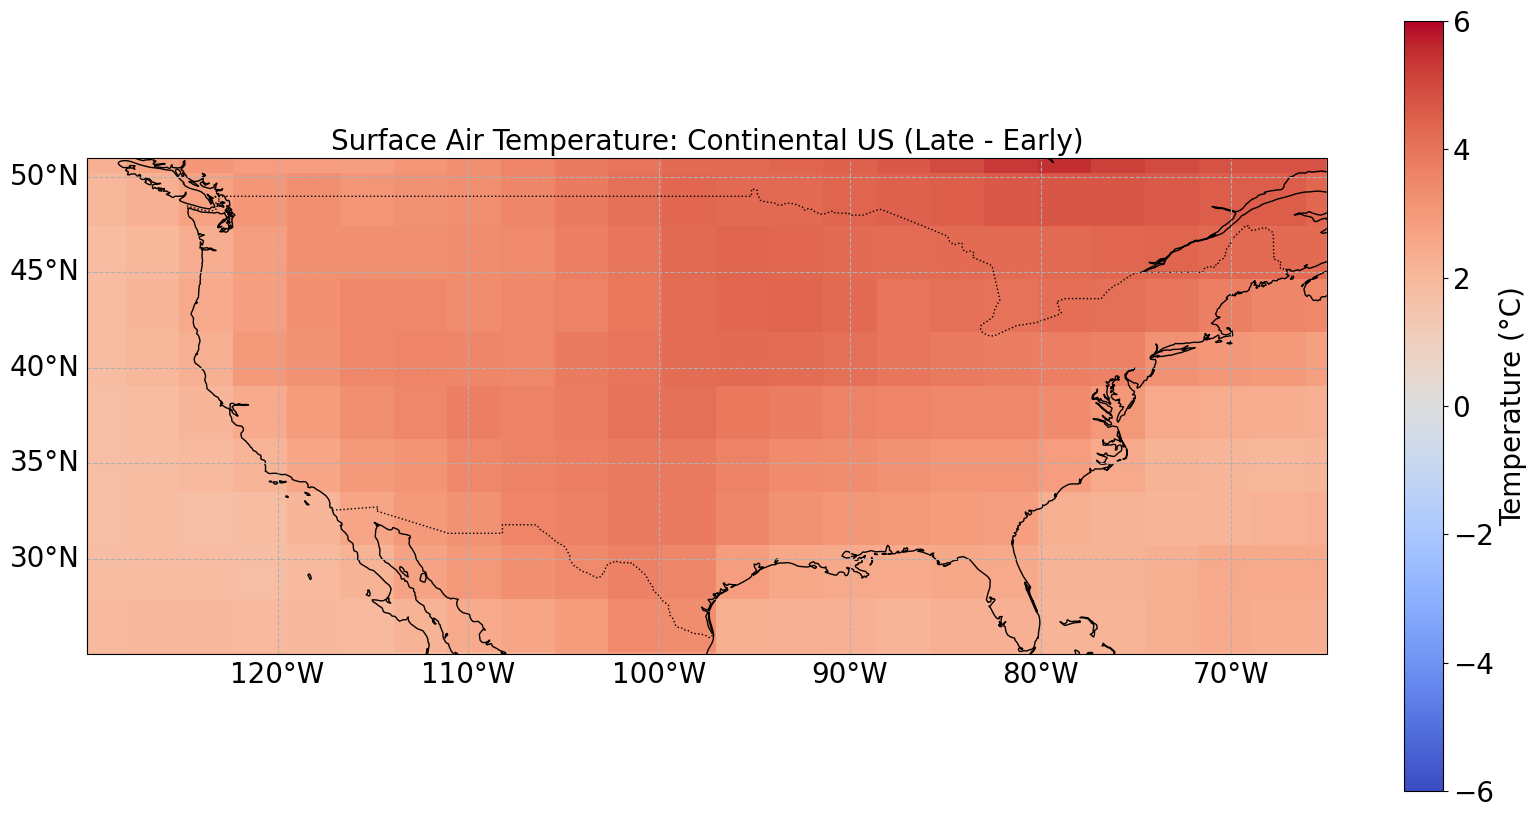

In [15]:
##### PLOT 1: Annual average

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})
# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(data_late_annmn.lon, data_late_annmn.lat, data_late_annmn.tas - data_early_annmn.tas, 
                     transform=map, cmap="coolwarm", vmin=-6, vmax=6)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)", fontsize=20)
cbar.ax.tick_params(labelsize=20)
# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Add title, show plot
ax.set_title("Surface Air Temperature: Continental US (Late - Early)", fontsize= 20)
plt.show()

As we expect, the temperature increases essentially everywhere across the US over the next 50 years.

Now let's see if anything is different when we look just at the DJF season:

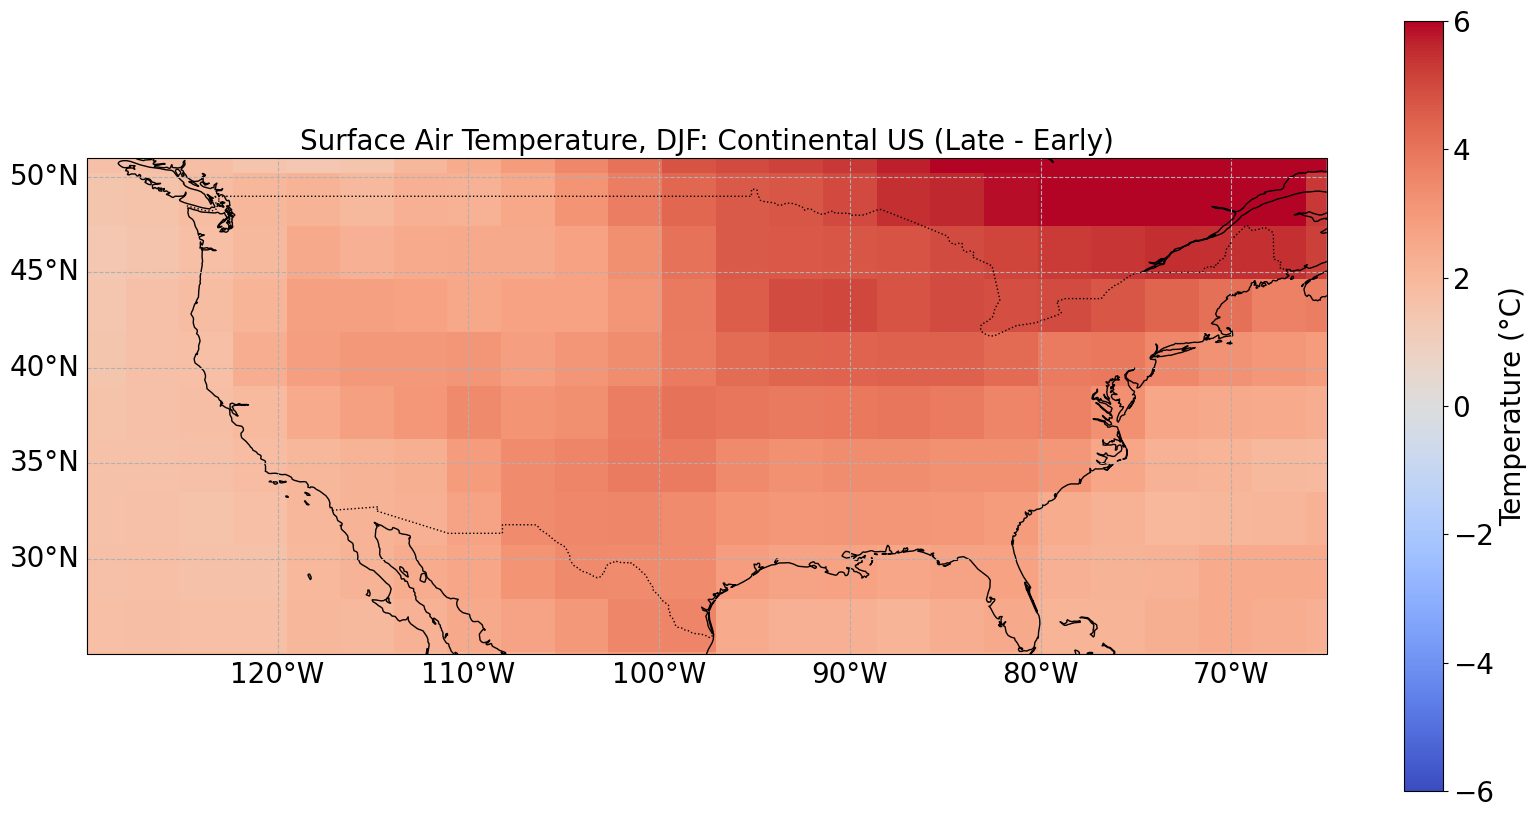

In [16]:
##### PLOT 2: DJF average

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})
# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(data_late_DJFmn.lon, data_late_DJFmn.lat, data_late_DJFmn.tas - data_early_DJFmn.tas, 
                     transform=map, cmap="coolwarm", vmin=-6, vmax=6)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)", fontsize=20)
cbar.ax.tick_params(labelsize=20)
# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Add title, show plot
ax.set_title("Surface Air Temperature, DJF: Continental US (Late - Early)", fontsize= 20)
plt.show()

Again, we see overall warming across the US. But there are definitely different patterns in the DJF map relative to the annual average: in particular, there's a lot more warming in the northeastern part of the country! 

The details of your particular analyses may vary, but having the ability to make maps in different seasons should come in handy in a variety of different contexts. 